# RooFit Tutorial: Fit Cosmological Models to Type 1a Supernova Data
### Created:  Summer 2017 Harrison B. Prosper
## Introduction
In this tutorial, I show how to use the probability modeling package __[RooFit](https://root.cern.ch/roofit-20-minutes)__, released with the CERN data analysis package __[ROOT](http://root.cern.ch)__, to perform simple fits of cosmological models to Type 1a supernova data. See the __minuit_example.ipynb__ to get some background to this problem. 

__prerequisite__: some familiarity with __[Python](http://www.python.org)__ and __[ROOT](http://root.cern.ch)__ is helpful.

## Other Dependencies

This tutorial uses the github package __[histutil](https://github.com/hbprosper)__, which contains some simple ROOT-based utilities. To install this package do
<div class="alert alert-block alert-info">
git clone https://github.com/hbprosper/histutil.git
</div>
and source the setup.sh script.

## PART 1: Create Probability Model

Note: if you want to make your plots interactive, do __%jsroot on__. But, it is off by default so that the LaTex annotation works correctly.

In [1]:
import os, sys
import ROOT
from histutil import setStyle, mkgraph, mkgraphErrors, mkhist1, Scribe
%jsroot off

Welcome to JupyROOT 6.10/02


### Model parameters

  * ID: model identifier
  * free: specifies whether parameter is free
  * name: name of parameter
  * guess: starting (or fixed) value of parameter
  * step: step size during minimization
  * min, max: parameter range

In [2]:
#                     ID    free, name,  guess,    step,   min,  max
PARAMS = {'LCDM' :    [0, [(True,  'OM',     1,   1.e-3,     0,   10),
                           (True,  'OL',     0,   1.e-3,     -10, 10),
                           (True,  'H0',    70,   1.e-2,     0,  200)]],
          
          'phantom':  [1, [(False, 'OM',     1,   1.e-3,     0,   10),
                           (False, 'OL',     0,   1.e-3,     -10, 10),
                           (True,  'H0',    70,   1.e-2,     0,  200),
                           (True,  'n',      2,   1.e-3,     0,   10)]]           
         }
# define ranges for redshifts and distance moduli
ZMIN  = 0.0 
ZMAX  = 1.5
MUMIN = 32.0
MUMAX = 48.0

### Choose model
   * MODEL = 'LCDM' or 'phantom'

In [3]:
MODEL = 'phantom'

### Compile C++ classes Model and CosmicCode
   * __Model__ defines $\Omega(a)$ for the cosmological models
   * __CosmicCode__ computes the distance modulus
   * The model identifier, ID, is used later in some inline C++ code. Therefore, ID needs to be added to the ROOT namespace; that is, ROOT needs to know about it.

In [4]:
def compileCode(modelname, modelparams):
    ROOT.gROOT.ProcessLine(open('../CosmicCode.cc').read())
    
    # make sure model name is valid
    if not modelparams.has_key(modelname):
        sys.exit("** unknown model %s" % modelname)
    
    # return model id and model parameters
    ID, params = modelparams[modelname]
    
    # add ID to ROOT namespace
    ROOT.gROOT.ProcessLine('int ID = %d;' % ID)
    return params

In [5]:
params = compileCode(MODEL, PARAMS)

### A useful bit of ROOT magic: mixing in a bit of C++
Here we create a bit of C++ code, which will be visible to both ROOT and Python. The object __code__ and the function __distanceModulus__ are used below in the definition of the probability model.

In [6]:
%%cpp -d
Model model(ID);
CosmicCode code(model);
double distanceModulus(double z, double OM, double OL, double H0, double n=2)
{
    double p[4] = {OM, OL, H0, n};
    return code.distanceModulus(z, p);
}


	phantom model



check that __ROOT.distanceModulus__ is visible to Python

In [7]:
print ROOT.distanceModulus(1, 0.3, 0.7, 70, 2)

43.9845970443


### Create workspace
Create an empty workspace called __Type1a__. This is useful for at least two reasons. First, you may wish to save the probability model you have created to a ROOT file. Second, it is much more convenient to use the workspace methods to build a model than to use the __[RooFit](https://root.cern.ch/roofit-20-minutes)__ C++ classes directly.

In [8]:
# suppress all messages except fatal ones
ROOT.RooMsgService.instance().setGlobalKillBelow(ROOT.RooFit.WARNING)

wspace = ROOT.RooWorkspace('Type1a')


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



### Create parameters
Create RooFit parameters using the workspace factory method. 

In [9]:
def createParameters(wspace, params,
                     zmin=ZMIN, zmax=ZMAX, mumin=MUMIN, mumax=MUMAX):    
    # measured redshift
    wspace.factory('z[%f, %f]' % (zmin, zmax))

    # measured distance modulus
    wspace.factory('x[%f, %f]' % (mumin, mumax))

    # distance modulus uncertainty
    wspace.factory('dx[0, 2]')

    wspace.defineSet('set_data',  'z,x,dx')
    
    # cosmological parameters
    args = 'z'
    for (free, name, guess, step, xmin, xmax) in params:
        cmd = '%s[%f, %f, %f]' % (name, guess, xmin, xmax)
        wspace.factory(cmd)
        args += ',%s' % name
        if not free:
            wspace.var(name).setConstant()

    wspace.defineSet('set_arguments', args)
    
    wspace.Print()
    return args

In [10]:
arguments = createParameters(wspace, params)
print 'arguments for distanceModulus: (%s)' % arguments

arguments for distanceModulus: (z,OM,OL,H0,n)

RooWorkspace(Type1a) Type1a contents

variables
---------
(H0,OL,OM,dx,n,x,z)

named sets
----------
set_arguments:(z,OM,OL,H0,n)
set_data:(z,x,dx)



### Load Type 1a supernova data 

In [11]:
# ---------------------------------------------------------
# read Type Ia data
# format: name, z, x, dx
# name:     name of supernova
# z         measured redshift of supernova
# x +/- dx: measured distance modulus
# ---------------------------------------------------------
def readData(wspace, filename):
    import os
    from array import array
    from string import split, atof
    if not os.path.exists(filename):
        sys.exit("** can't open file %s" % filename)
        
    # skip first 5 lines and convert 2nd through 4th
    # columns to floats
    data = map(lambda x: map(atof, x[1:-1]),
                   map(split,
                           open(filename).readlines()[5:]))
    
    # create a RooFit data set
    set_data = wspace.set('set_data')
    dataset = ROOT.RooDataSet('data', 'Type 1a data', set_data)

    print "number of observations: %d" % len(data)
    print "%5s\t%10s\t%10s +/- %-10s" % ('', 'z', 'x', 'dx')
    
    # and fill it with the supernova data
    # also copy data to arrays
    z  = array('d')
    x  = array('d')
    dz = array('d')
    dx = array('d')
    for ii, d in enumerate(data):
        z.append(d[0])
        x.append(d[1])
        dz.append(0)
        dx.append(d[2])
        
        set_data['z'].setVal(z[-1])
        set_data['x'].setVal(x[-1])
        set_data['dx'].setVal(dx[-1])
        dataset.add(set_data)

        if ii % 100 == 0:
            print "%5d\t%10.3f\t%10.4f +/- %-10.4f"%\
              (ii, z[-1], x[-1], dx[-1])
    
    # import data set into workspace
    getattr(wspace, 'import')(dataset)
    
    wspace.Print()
    return (z, x, dz, dx)

In [12]:
data = readData(wspace, '../SCPUnion2.1_mu_vs_z.txt')

number of observations: 580
     	         z	         x +/- dx        
    0	     0.028	   35.3466 +/- 0.2239    
  100	     0.065	   37.3067 +/- 0.1628    
  200	     0.194	   39.9615 +/- 0.1264    
  300	     0.620	   43.2280 +/- 0.3903    
  400	     0.710	   43.0220 +/- 0.1843    
  500	     0.564	   42.3729 +/- 0.2920    

RooWorkspace(Type1a) Type1a contents

variables
---------
(H0,OL,OM,dx,n,x,z)

datasets
--------
RooDataSet::data(z,x,dx)

named sets
----------
set_arguments:(z,OM,OL,H0,n)
set_data:(z,x,dx)



In [13]:
setStyle()

def plotData(data, code, zmin=ZMIN, zmax=ZMAX, mumin=MUMIN, mumax=MUMAX):
    from array import array

    print "plot data"
    
    z, x, dz, dx = data
    ndata   = len(z)
    print "number of observations: %d" % ndata
    
    g = mkgraphErrors(z, x, dz, dx,
                      "redshift z",
                      "distance modulus #mu", 
                      zmin, zmax,
                      ymin=mumin,
                      ymax=mumax, 
                      color=ROOT.kBlack)
    ROOT.SetOwnership(g, 0)
    g.SetName('dataplot')
    g.SetTitle('')
    g.SetMarkerSize(0.2)
    
    c = ROOT.TCanvas("fig_data", "SN1a data", 500, 500)
    ROOT.SetOwnership(c, 0)
    
    c.cd()
    g.Draw("ap")
    
    xpos = 0.32
    ypos = 0.50
    textsize = 0.035
    
    scribe = Scribe(xpos, ypos, textsize)
    ROOT.SetOwnership(scribe, 0)
    scribe.write("The Union2.1 Compilation")
    scribe.write("The Supernova Cosmology Project")
    scribe.write("http://supernova.lbl.gov/Union/figures")
    scribe.write("")
    scribe.write("#mu = 5 log_{10}d_{L}(z) + C, d_{L} = (1+z)r")    
    c.SaveAs('.pdf')
    c.Draw()

    return g 

plot data
number of observations: 580


Info in <TCanvas::Print>: pdf file ./fig_data.pdf has been created


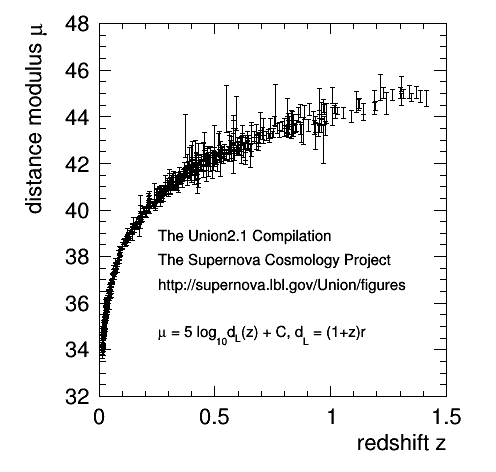

In [14]:
gd = plotData(data, ROOT.code)

### Create probability model
We assume a Gaussian probability density function (pdf),

$$f(x \, | \, z, \sigma, \theta) = \textrm{Gauss}(x, \mu(z, \theta), \sigma),$$

where $\theta$ are the parameters of the cosmological model. Neglecting correlations amongst the data, the likelihood of the data is

$$p(x \,| \, z, \sigma, \theta) = \prod_{i=1}^N \, f(x_i \, | \, z_i, \sigma_i, \theta),$$

with $N = 580$. For a Bayesian calculation, we would, in addition, need to specify a prior density $\pi(\theta)$ for the cosmological parameters. We assume that $z_i$ and $\sigma_i$ are known with negligible uncertainty.

In [15]:
def createModel(wspace, arguments):
    #--------------------------------------------------------------    
    # create distance modulus expression
    # "mu".
    # note use of compiled C++ program
    # for expressions that are too
    # complicated to be written inline
    #--------------------------------------------------------------
    print "create model"
 
    set_arguments = wspace.set('set_arguments')
    cmd = 'distanceModulus(%s)' % arguments
    print cmd
    
    mu  = ROOT.RooFormulaVar('mu', '#mu', cmd, ROOT.RooArgList(set_arguments))
    
    # import the "mu" expression into workspace
    getattr(wspace,'import')(mu)

    # finally, create probability model
    wspace.factory('Gaussian::model(x, mu, dx)')
    wspace.Print()

In [16]:
createModel(wspace, arguments)

create model
distanceModulus(z,OM,OL,H0,n)

RooWorkspace(Type1a) Type1a contents

variables
---------
(H0,OL,OM,dx,n,x,z)

p.d.f.s
-------
RooGaussian::model[ x=x mean=mu sigma=dx ] = 0.601823

functions
--------
RooFormulaVar::mu[ actualVars=(z,OM,OL,H0,n) formula="distanceModulus(z,OM,OL,H0,n)" ] = 42.7578

datasets
--------
RooDataSet::data(z,x,dx)

named sets
----------
set_arguments:(z,OM,OL,H0,n)
set_data:(z,x,dx)



### Save workspace to a ROOT file 

In [17]:
filename = '%s_workspace.root' % MODEL
if wspace.writeToFile(filename) != 0:
    print "** problem saveing workspace to ROOT file %s" % filename




## PART 2: Perform Fit

Ordinarily, this part would be performed in a separate session, which would require loading the workspace back into memory as follows:

```python
    filename = '%s_workspace.root' % MODEL
    rfile = TFile(filename)
    if not rfile.IsOpen():
        exit("** can't open file %s" % filename)

    name = 'Type1a'
    wspace = rfile.Get(name)
    if wspace == None:
        exit("** can't get workspace %s from file %s" % (name, filename))
```

However, we shall just continue with the workspace already in memory.

In [18]:
wspace.Print()


RooWorkspace(Type1a) Type1a contents

variables
---------
(H0,OL,OM,dx,n,x,z)

p.d.f.s
-------
RooGaussian::model[ x=x mean=mu sigma=dx ] = 0.601823

functions
--------
RooFormulaVar::mu[ actualVars=(z,OM,OL,H0,n) formula="distanceModulus(z,OM,OL,H0,n)" ] = 42.7578

datasets
--------
RooDataSet::data(z,x,dx)

named sets
----------
set_arguments:(z,OM,OL,H0,n)
set_data:(z,x,dx)



In [19]:
def performFit(wspace, params, printLevel=-1):
    print "="*80
    print "performing fit..."
    swatch = ROOT.TStopwatch()
    swatch.Start()

    # save results of fit to results
    ROOT.RooMsgService.instance().setGlobalKillBelow(ROOT.RooFit.FATAL)
    r = wspace.pdf('model').fitTo(wspace.data('data'),
                                  ROOT.RooFit.Save(),
                                  ROOT.RooFit.PrintLevel(printLevel))
    print "real time: %10.3f s" % swatch.RealTime()
    print "="*80
    r.Print()
    print "="*80

    results = []
    npar = 0
    for p in params:
        free, name = p[:2]
        results.append((wspace.var(name).getVal(), wspace.var(name).getError()))
        if free:
            npar += 1
    return (results, npar)

In [20]:
results, npar = performFit(wspace, params)

performing fit...
real time:      2.941 s

  RooFitResult: minimized FCN value: 1447.61, estimated distance to minimum: 8.69769e-10
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
                    H0    7.0425e+01 +/-  4.53e-01
                     n    2.8213e+00 +/-  1.87e-01



## Plot Results

In [21]:
def annotate(modelname, scribe, results, offset=0.01):
    if modelname == 'LCDM':
        OM = tuple(results[0])
        OL = tuple(results[1])
        scribe.write("#LambdaCDM model")
        scribe.write("")
        scribe.write("#Omega(a) = #frac{#Omega_{M}}{a^{3}} + "
              "#frac{(1 - #Omega_{M} - #Omega_{#Lambda})}{a^{2}}"
                      " + #Omega_{#Lambda}",
                      offset)
        scribe.write("")
        scribe.write("#Omega_{M} = %5.2f #pm %-5.2f" % OM,
                      offset)
        scribe.write("#Omega_{#Lambda} = %5.2f #pm %-5.2f " % OL,
                      offset)
    else:
        n, dn = results[3]
        x = 3.0/(2*n)
        G = ROOT.TMath.Gamma(x)
        T = G*ROOT.TMath.Sqrt(2.718)*2**x/n        
        scribe.write("phantom model")
        scribe.write("")
        scribe.write("#Omega(a) = #frac{#Omega_{M}}{a^{3}} + "
                  "#frac{e^{a^{n}-1} - #Omega_{M}}{a^{3}}", offset)
        scribe.write("")
        scribe.write("H_{0}t = #sqrt{e} 2^{3/(2n)} #Gamma(3/(2n), a^{n}/2)/n", offset)
        scribe.write("")
        scribe.write("H_{0}t_{rip} = #sqrt{e} 2^{3/(2n)} #Gamma(3/(2n))/n = %4.2f" % T,
                      offset)
        scribe.write("")
        scribe.write("where #Gamma(s, x) = #int_{0}^{x} t^{s-1} e^{-t} dt", offset)
        scribe.write("and n = %4.2f" % n, offset)    

In [22]:
def plotModel(modelname, code, results, npar,
              gd, data, 
              zmin=ZMIN, zmax=ZMAX, mumin=MUMIN, mumax=MUMAX):
    from array import array
    p = array('d')
    for value, error in results:
        p.append(value)

    z, x, dz, dx = data
    ndata = len(z)
    
    # compute chisq
    chi2 = 0.0
    for i in xrange(ndata):    
        mu = code.distanceModulus(z[i], p)
        c = (x[i] - mu)/dx[i]
        chi2 += c*c        
    NDF = ndata - npar # number of degrees of freedom
    
    # compute curve
    nz = 100
    zstep = (zmax - zmin) / nz
    zz = array('d')
    mu = array('d')
    for ii in xrange(nz):
        zz.append( (ii+0.5)*zstep )
        mu.append( code.distanceModulus(zz[-1], p) )

    g = mkgraph(zz, mu,
                "redshift z", 
                "distance modulus #mu", 
                zmin, zmax, color=ROOT.kRed, lwidth=2)
    ROOT.SetOwnership(g, 0)
    g.SetName('model')
    g.SetTitle('')
    
    c = ROOT.TCanvas("fig_%s_fit" % modelname, "SN1a model fit", 500, 500)
    ROOT.SetOwnership(c, 0)
    
    c.cd()
    g.Draw('ac')
    gd.Draw('psame')
    g.Draw('csame')
    
    xpos = 0.32
    ypos = 0.50
    textsize = 0.035
    scribe = Scribe(xpos, ypos, textsize)
    ROOT.SetOwnership(scribe, 0)
    scribe.write("The Union2.1 Compilation")
    scribe.write("The Supernova Cosmology Project")
    scribe.write("http://supernova.lbl.gov/Union/figures")
    scribe.write("")
    scribe.write("#chi^{2} / NDF = %5.1f / %d = %5.2f" % (chi2, NDF, chi2/NDF))  

    c.Draw()
    c.SaveAs(".pdf")

Info in <TCanvas::Print>: pdf file ./fig_phantom_fit.pdf has been created


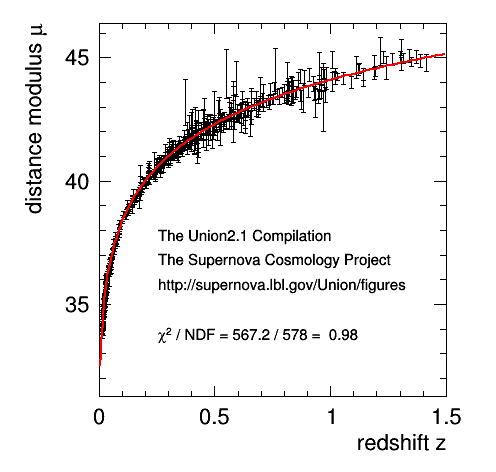

In [23]:
plotModel(MODEL, ROOT.code, results, npar, gd, data)

In [24]:
def plotScaleFactor(modelname, code, results, amax=10, tmax=2):
    from array import array

    p = array('d')
    for value, error in results:
        p.append(value)
        
    # create a vs H0 t plot
    a = array('d'); a.fromlist(code.N*[0])
    t = array('d'); t.fromlist(code.N*[0])
    code.scaleFactor(amax, p, t, a)
    g = mkgraph(t, a,
                "H_{0}t}", "a(t)", 
                0, tmax, color=ROOT.kBlue, lwidth=2)
    ROOT.SetOwnership(g, 0)
    g.SetName('scaleFactor')

    # create horizontal line at a = 1
    x = array('d'); x.append(0); x.append(tmax)
    y = array('d'); y.append(1); y.append(1)
    glineH = mkgraph(x, y, '', '', 0, tmax, 
                     color=ROOT.kMagenta+1, lwidth=2)
    ROOT.SetOwnership(glineH, 0)
    glineH.SetName('line')
    
    c = ROOT.TCanvas("fig_%s_scaleFactor" % modelname, 
                     "SN1a scalefactor",
                     500, 500)
    ROOT.SetOwnership(c, 0)
    c.cd()
    htmp = mkhist1('htmp', 'H_{0}t', 'a(t)',
                       50, 0, tmax, ymin=0, ymax=10)
    ROOT.SetOwnership(htmp, 0)
    htmp.Draw()
    g.Draw('csame')
    glineH.Draw('csame')

    offset = 0.05
    xpos = 0.25
    ypos = 0.87
    scribe = Scribe(xpos, ypos)
    ROOT.SetOwnership(scribe, 0)
    annotate(modelname, scribe, results, offset)
    c.Draw()
    c.SaveAs(".pdf")    

Info in <TCanvas::Print>: pdf file ./fig_phantom_scaleFactor.pdf has been created


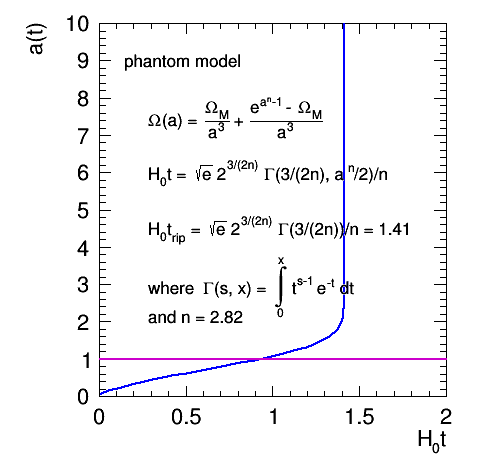

In [25]:
plotScaleFactor(MODEL, ROOT.code, results)